# Testing a Rainfall Region Classifier

This notebook demonstrates:

1) How to generate training and testing data

2) Examining pertinent rainfall region features

3) Passing these features into a random forest classifier

4) Basic assessment of the classifier

5) Exploring the feature space to see how this modifies the classification

# Examine raw radar data from May 2009

Pixel values represent bins of 5 dBZ from 0 - 16 (0 - 80 dBZ).

Text(0.5,1,'Reflectivity valid at 1300 UTC on 8 May 2009')

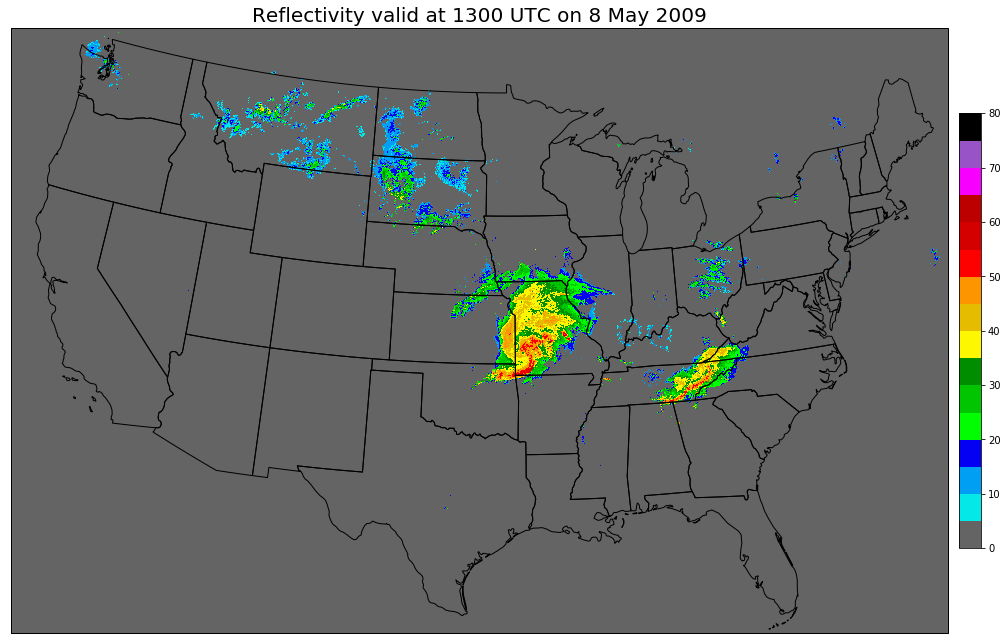

In [1]:
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap
from utils.mapping_help import *
from scipy.ndimage.measurements import label
from skimage.measure import regionprops
from scipy.ndimage.morphology import binary_fill_holes
from utils.features import calc_features, feature_list
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

def draw_geom_axes(num_rows, num_cols, count, 
                   from_proj=ccrs.PlateCarree(),
                   to_proj=ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000),
                   lon_w=-120, lon_e=-73, lat_s=50, lat_n=23,
                   line_colors='k'):
    
    ax = plt.subplot(num_rows, num_cols, count, projection=to_proj)
    ax.set_extent([lon_w, lon_e, lat_s, lat_n])
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural', name=shapename)

    for state, info in zip(shpreader.Reader(states_shp).geometries(), 
                       shpreader.Reader(states_shp).records()):
        if info.attributes['admin'] == 'United States of America':

            ax.add_geometries([state], from_proj,
                              facecolor='None', edgecolor=line_colors)
    return ax

data_location = "../data"

img = imread(data_location + "/radar_data/BREF_090508_1300.png", pilmode='P')

view = draw_geom_axes(1, 1, 1)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

plt.title("Reflectivity valid at 1300 UTC on 8 May 2009", fontsize=20)

# Read in hand-labeled data and use it to filter the raw radar image 

Having both data sources is important, because the hand-labeled image has pixel intensities that do not inuitively map to dBZ values, whereas the pixel intensities for the raw data map directly to dBZ values.

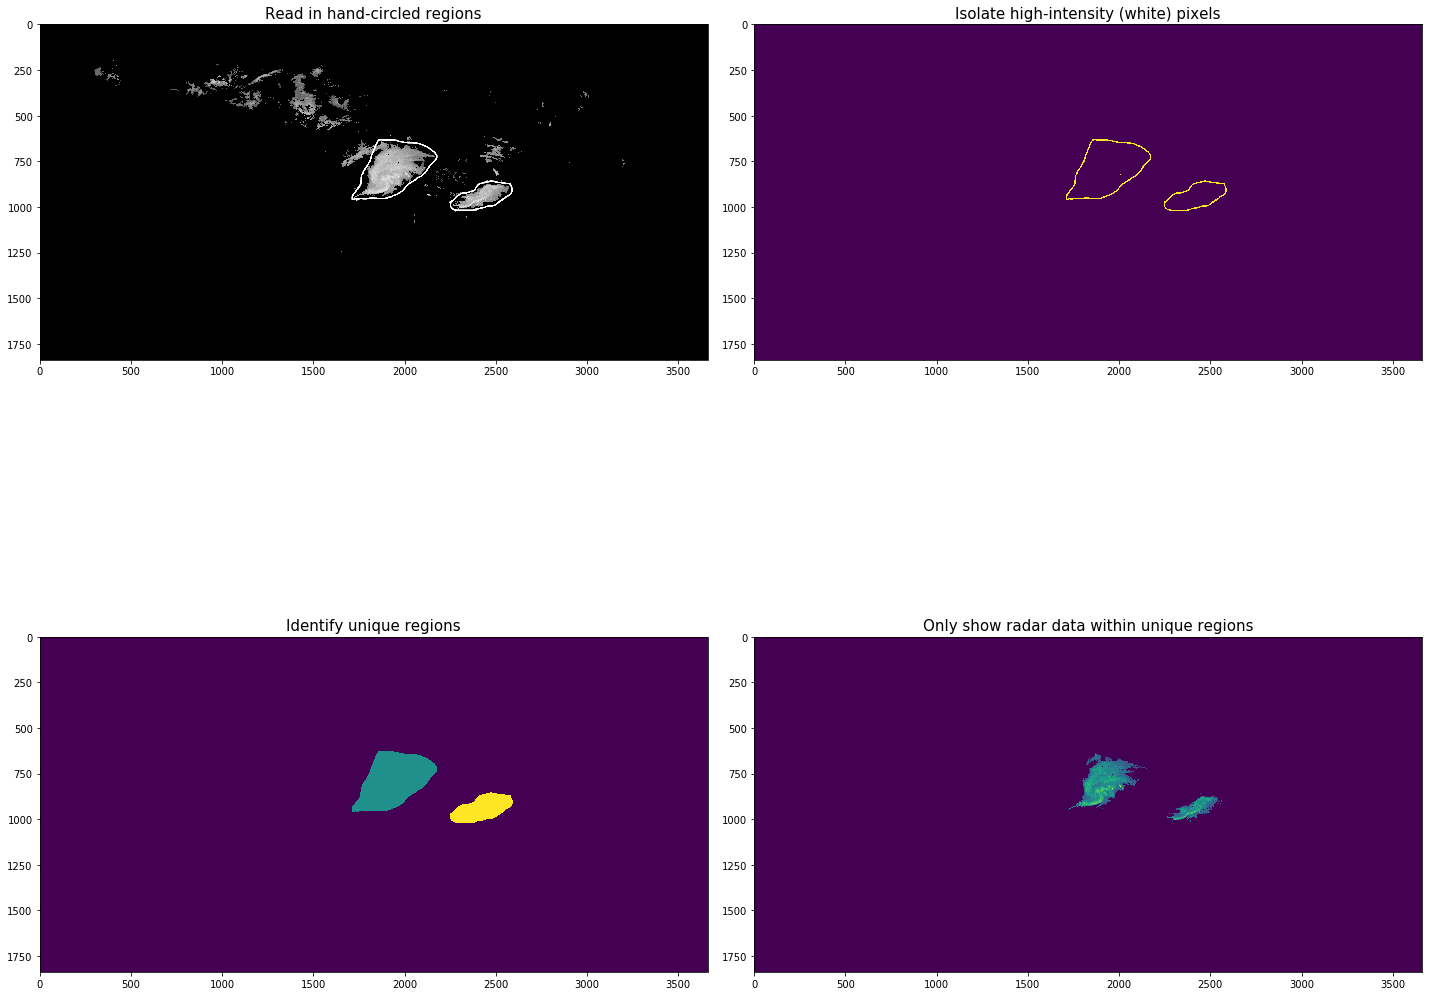

In [2]:
plt.rcParams['figure.figsize'] = 20, 20

circled = imread(data_location + "/radar_data/BREF_090508_1300_circled.png")

ax = plt.subplot(2, 2, 1)
ax.imshow(circled)
ax.set_title("Read in hand-circled regions", fontsize=15)

circled = circled[:,:,0]>250

ax = plt.subplot(2, 2, 2)
ax.imshow(circled)
ax.set_title("Isolate high-intensity (white) pixels", fontsize=15)

ax = plt.subplot(2, 2, 3)

circled, number = label(binary_fill_holes(circled), np.ones((3,3)))
ax.imshow(circled)
ax.set_title("Identify unique regions", fontsize=15)

ax = plt.subplot(2, 2, 4)

circled = circled * (1*img >= 4)
ax.imshow(img*(circled>0))
ax.set_title("Only show radar data within unique regions", fontsize=15)

plt.tight_layout()

# We want to extract the following features from the samples:

In [3]:
feature_list = ['area', 'convex_area', 'eccentricity', 
                'intense_area', 'convection_area',
                'convection_stratiform_ratio', 'intense_stratiform_ratio',
                'intense_convection_ratio', 'mean_intensity', 'max_intensity',
                'intensity_variance', 'major_axis_length', 'minor_axis_length',
                'solidity']

# These can all be obtained or derived through scikit-image's regionprops function.

This is one approach for performing this task.  You can also use derived features from well-established storm-tracking software packages.

http://wdssii.org/

https://dtcenter.org/met/users/

http://www.rap.ucar.edu/projects/titan

In [4]:
for props in regionprops(circled, intensity_image=img):
    
    features = calc_features(props=props)
    [print(x + ":" + str(y)) for (x, y) in features.items()];
    print("\n")

area:218872
convex_area:343384
eccentricity:0.7485591570667407
intense_area:8852
convection_area:60480
convection_stratiform_ratio:0.2763258891041339
intense_stratiform_ratio:0.04044372966848204
intense_convection_ratio:0.14636243386243386
mean_intensity:32.33643408019299
max_intensity:70
intensity_variance:71.06936629660673
major_axis_length:690.2774522580476
minor_axis_length:457.7008979107097
solidity:0.6373971996365585
filename:None


area:70040
convex_area:117040
eccentricity:0.9496242132761378
intense_area:2200
convection_area:16376
convection_stratiform_ratio:0.23380925185608223
intense_stratiform_ratio:0.03141062250142775
intense_convection_ratio:0.134342940889106
mean_intensity:30.696744717304398
max_intensity:55
intensity_variance:71.81323326378562
major_axis_length:557.5319121641141
minor_axis_length:174.72542538072526
solidity:0.5984278879015721
filename:None




/home/alex/anaconda3/envs/unidata18/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/alex/anaconda3/envs/unidata18/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


CSV files for this example are in the "../data/training" folder.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = 10, 10

data_loc = "../data"
labels = ['MCS', 'Unorganized', 'Tropical', 'Synoptic', 'Clutter']

# Read in and examine training data

In [6]:
df_train = pd.read_csv(data_loc + "/training/sample_train_data.csv")
df_train['label_name'] = [labels[x] for x in df_train.label.values]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 25 columns):
datetime                       399 non-null object
index                          399 non-null int64
filename                       399 non-null object
mean_intensity                 399 non-null float64
solidity                       399 non-null float64
intensity_variance             399 non-null float64
intense_convection_ratio       399 non-null float64
convection_stratiform_ratio    399 non-null float64
area                           399 non-null int64
convection_area                399 non-null int64
max_intensity                  399 non-null int64
minor_axis_length              399 non-null float64
intense_area                   399 non-null int64
eccentricity                   399 non-null float64
convex_area                    399 non-null int64
intense_stratiform_ratio       399 non-null float64
major_axis_length              399 non-null float64
label                    

In [7]:
df_train.sample(5)

,datetime,index,filename,mean_intensity,solidity,intensity_variance,intense_convection_ratio,convection_stratiform_ratio,area,convection_area,...,intense_stratiform_ratio,major_axis_length,label,minor_major_ratio,xmax,xmin,ymax,ymin,label1,label_name
52,2010-06-10 19:35:00,1468,extracted/mcs_files/mcs_BREF_100610_1935_000.png,29.990049,0.468560,63.814972,0.077638,0.193007,102504,19784,...,0.014985,630.046851,0,0.461731,2136,1834,747,430,1,MCS
198,2006-09-01 02:45:00,3573,extracted/tropical_files/tropical_BREF_060901_...,28.472944,0.489122,46.932290,0.025566,0.106623,217176,23156,...,0.002726,742.941927,2,0.664546,2989,2617,1189,746,0,Tropical
233,2011-08-27 15:40:00,3645,extracted/tropical_files/tropical_BREF_110827_...,30.296892,0.596639,47.473885,0.014967,0.153646,273096,41960,...,0.002300,884.580310,2,0.565055,3069,2653,1121,701,0,Tropical
329,2007-08-30 03:15:00,284,extracted/clutter_files/clutter_BREF_070830_03...,20.791367,0.635429,3.330573,0.000000,0.000000,4448,0,...,0.000000,98.753469,4,0.821913,2349,2294,672,630,0,Clutter
53,2007-06-06 22:05:00,1086,extracted/mcs_files/mcs_BREF_070606_2205_002.png,31.685524,0.520498,96.506269,0.280836,0.284595,27576,7848,...,0.079925,330.790168,0,0.562609,2611,2491,1476,1322,1,MCS


# Read in and examine testing data

In [8]:
df_test = pd.read_csv(data_loc + "/training/sample_test_data.csv")
df_test['label_name'] = [labels[x] for x in df_test.label.values]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
datetime                       100 non-null object
index                          100 non-null int64
filename                       100 non-null object
mean_intensity                 100 non-null float64
solidity                       100 non-null float64
intensity_variance             100 non-null float64
intense_convection_ratio       100 non-null float64
convection_stratiform_ratio    100 non-null float64
area                           100 non-null int64
convection_area                100 non-null int64
max_intensity                  100 non-null int64
minor_axis_length              100 non-null float64
intense_area                   100 non-null int64
eccentricity                   100 non-null float64
convex_area                    100 non-null int64
intense_stratiform_ratio       100 non-null float64
major_axis_length              100 non-null float64
label                     

In [9]:
df_test.sample(5)

,datetime,index,filename,mean_intensity,solidity,intensity_variance,intense_convection_ratio,convection_stratiform_ratio,area,convection_area,...,intense_stratiform_ratio,major_axis_length,label,minor_major_ratio,xmax,xmin,ymax,ymin,label1,label_name
42,2005-08-25 21:45:00,3535,extracted/tropical_files/tropical_BREF_050825_...,28.076192,0.647162,47.433410,0.034060,0.110300,94760,10452,...,0.003757,393.641003,2,0.957803,2722,2484,1655,1434,0,Tropical
24,2005-06-07 20:00:00,2268,extracted/non_mcs_files/non_mcs_BREF_050607_20...,29.391741,0.688172,74.881137,0.220238,0.187500,3584,672,...,0.041295,92.263003,1,0.634883,1831,1794,931,883,0,Unorganized
38,2003-06-19 01:25:00,1898,extracted/non_mcs_files/non_mcs_BREF_030619_01...,25.951043,0.384568,59.187812,0.282051,0.093900,4984,468,...,0.026485,110.452267,1,0.878419,1179,1099,1182,1126,0,Unorganized
4,2005-06-29 10:50:00,886,extracted/mcs_files/mcs_BREF_050629_1050_002.png,31.103538,0.469183,85.141488,0.225011,0.251352,35504,8924,...,0.056557,433.686443,0,0.432666,1894,1746,659,453,1,MCS
69,2004-09-18 22:25:00,3195,extracted/synoptic_files/synoptic_BREF_040918_...,25.196759,0.365775,34.528457,0.008547,0.032853,99716,3276,...,0.000281,1175.874316,3,0.180910,3440,3127,750,313,0,Synoptic


# Distribution of area values for each label

Text(0,0.5,'km $^2$')

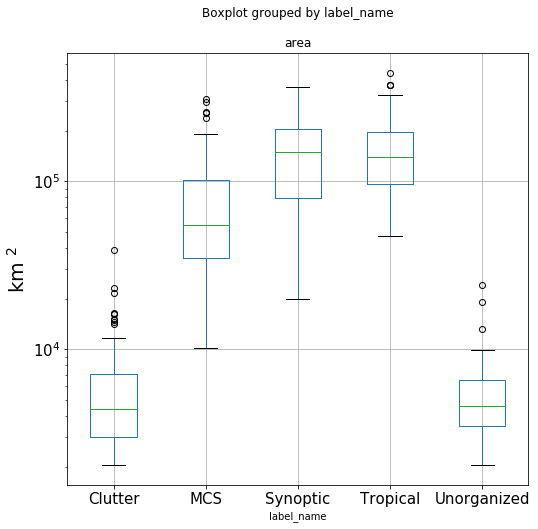

In [10]:
ax = df_train.boxplot(column='area', by='label_name', figsize=(8,8), fontsize=15)

ax.set_yscale('log')
ax.set_ylabel("km $^2$", fontsize=20)

# Distribution of mean intensity values for each label

Text(0,0.5,'Mean dBZ')

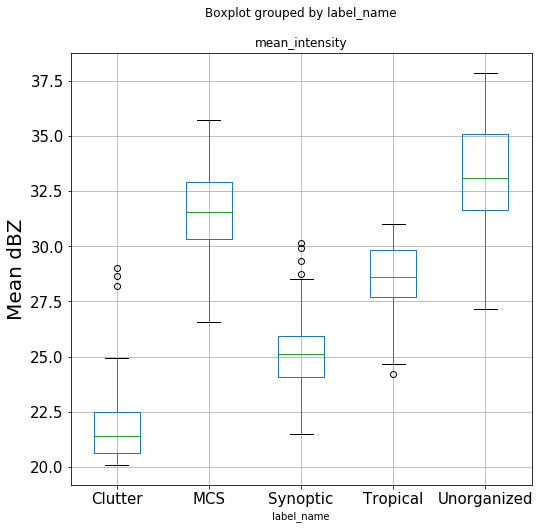

In [11]:
ax = df_train.boxplot(column='mean_intensity', by='label_name', figsize=(8,8), fontsize=15)
ax.set_ylabel("Mean dBZ",fontsize=20)

# Build Random Forest Classifier and Examine Performance Metrics

Precision = Out of all predictions of class X, how many are correct?

Recall = Out of all actual samples of class X, how many are labeled as class X? (Probability of detection)

Accuracy = Out of all predictions, how many are correct?

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(df_train[['area', 'mean_intensity']].values, df_train.label.values)

predicted = rf_clf.predict(df_test[['area', 'mean_intensity']].values)
expected = df_test.label.values

print("Classification report for classifier %s:\n%s\n"
      % (rf_clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

print("\nAccuracy:" + str(metrics.accuracy_score(expected, predicted)))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False):
             precision    recall  f1-score   support

          0       0.88      0.75      0.81        20
          1       0.94      0.80      0.86        20
          2       0.65      0.85      0.74        20
          3       0.75      0.60      0.67        20
          4       0.79      0.95      0.86        20

avg / total       0.80      0.79      0.79       100


Confusion matrix:
[[15  1  3  0  1]
 [ 1 16  0  0  3]
 [ 0  0 17  3  0]
 [ 1  0  6 12  1]
 [ 0  0  0  1 19]]

Accuracy:0.79


In [13]:
plt.rcParams['figure.figsize'] = 14, 14
from ipywidgets.widgets import BoundedFloatText as fs
from ipywidgets import interact, Layout

plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

df = pd.concat([df_train, df_test])

labels= ['MCS', 'Unorganized', 'Tropical', 'Synoptic', 'Clutter']

def get_label_2f(area=fs(value=218872, min=1000, max=500000, 
                      description='Area',
                      continuous_update=False),
                 mean_intensity=fs(value=32.3364340802, min=20, max=40, 
                                description='Mean Intensity',
                                continuous_update=False)):
    
    
    vector = np.array([area, mean_intensity])

    class_name = rf_clf.predict(vector.reshape(1,-1))[0]
    proba = rf_clf.predict_proba(vector.reshape(1,-1))[0]
    
    perc = float(proba[np.argmax(proba)])*100
    
    for color, label in zip(['r', 'g', 'b', 'y', 'k'], labels):
              
        t_df = df[df.label_name==label]
        plt.scatter(t_df.area, t_df.mean_intensity, c=color, label=label)


    plt.xscale('symlog')
    plt.legend(prop={'size':20})
    plt.xlim(1000, 600000)
    plt.title(labels[class_name] +  ": %.1f" % perc + '%', fontsize=30)
    plt.ylabel("Mean Intensity (dBZ)", fontsize=30)
    plt.xlabel("Area (" + r'$km^2$' + ")", fontsize=30)
    
    plt.plot(area, mean_intensity, 'w*', markersize=80)
    plt.plot(area, mean_intensity, 'm*', markersize=50)

    
interact(get_label_2f)

interactive(children=(BoundedFloatText(value=218872.0, description='Area', max=500000.0, min=1000.0), BoundedF…

<function __main__.get_label_2f(area=BoundedFloatText(value=218872.0, description='Area', max=500000.0, min=1000.0), mean_intensity=BoundedFloatText(value=32.3364340802, description='Mean Intensity', max=40.0, min=20.0))>

In [14]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(df_train[feature_list].values, df_train.label.values)

predicted = rf_clf.predict(df_test[feature_list].values)
expected = df_test.label.values

print("Classification report for classifier %s:\n%s\n"
      % (rf_clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

print("\nAccuracy:" + str(metrics.accuracy_score(expected, predicted)))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False):
             precision    recall  f1-score   support

          0       1.00      0.90      0.95        20
          1       0.94      0.80      0.86        20
          2       0.85      0.85      0.85        20
          3       0.85      0.85      0.85        20
          4       0.80      1.00      0.89        20

avg / total       0.89      0.88      0.88       100


Confusion matrix:
[[18  1  1  0  0]
 [ 0 16  0  0  4]
 [ 0  0 17  3  0]
 [ 0  0  2 17  1]
 [ 0  0  0  0 20]]

Accuracy:0.88


In [15]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

np.array(feature_list)[indices]

for f in range(df_train[feature_list].values.shape[1]):
    print("%d. (%s) feature %d (%f)" % (f+1, feature_list[indices[f]], indices[f], importances[indices[f]]))

1. (intensity_variance) feature 10 (0.135416)
2. (area) feature 0 (0.126888)
3. (intense_stratiform_ratio) feature 6 (0.090906)
4. (mean_intensity) feature 8 (0.088760)
5. (convex_area) feature 1 (0.085777)
6. (convection_stratiform_ratio) feature 5 (0.079348)
7. (convection_area) feature 4 (0.076705)
8. (major_axis_length) feature 11 (0.068580)
9. (intense_convection_ratio) feature 7 (0.064249)
10. (minor_axis_length) feature 12 (0.055536)
11. (intense_area) feature 3 (0.044203)
12. (eccentricity) feature 2 (0.029446)
13. (max_intensity) feature 9 (0.028128)
14. (solidity) feature 13 (0.026057)


In [16]:
import pickle

pickle.dump(rf_clf, open(data_loc + "/classifiers/my_random_forest.pkl", "wb"))